Purpose
------------
    
### Calculate the C:H:O:N:P stoichiometry of phytoplankton organic matter using key environmental predictors.


Authors : Pearse J. Buchanan, Tatsuro Tanioka & Allison Moreno


In [1]:
### import packages


import sys
print("python version =",sys.version[:5])

import os
import numpy as np
import xarray as xr
import netCDF4 as nc

# plotting packages
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sb
sb.set(style='ticks')
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
import cmocean.cm as cmo
from cmocean.tools import lighten

from tqdm import tqdm


print("numpy version =", np.__version__)
print("xarray version =", xr.__version__)
print("seaborn version =", sb.__version__)
print("matplotlib version =", sys.modules[plt.__package__].__version__)
print("cartopy version =", sys.modules[ccrs.__package__].__version__)
print("cmocean version =", sys.modules[cmo.__package__].__version__)




python version = 3.7.6
numpy version = 1.20.3
xarray version = 0.18.2
seaborn version = 0.11.2
matplotlib version = 3.4.2
cartopy version = 0.18.0
cmocean version = 2.0


# Prepare data

Load in the temperature, nutrient and PAR data and also a satellite estimate of phytoplankton growth rate


In [2]:
os.chdir("C://Users//pearseb//Dropbox//PostDoc//collaborations//Tatsuro & Moreno//data")

# Temperature
data = nc.Dataset('woa18_mldtem_clim.nc','r')
tem = data.variables['TEM1'][...]
lon = data.variables['LONGITUDE'][...]
lat = data.variables['LATITUDE'][...]
dep = data.variables['DEPTH'][...]

# Nitrate
data = nc.Dataset('woa18_mldnit_clim.nc','r')
nit = data.variables['NIT1'][...]

# Phosphate
data = nc.Dataset('woa18_mldpho_clim.nc','r')
pho = data.variables['PHO1'][...]

# Mixed layer depth and growth rate
data = nc.Dataset('TFM20_Monthly.nc','r')
mld = np.ma.squeeze(data.variables['MLD'][...])
mu = np.ma.squeeze(data.variables['MU_CBPM'][...]) / 24.0   # convert growth rate from day-1 to hour-1
# flip y axis for MLD and MU
mask = np.ma.getmask(mld)
mask = np.flip(mask, axis=1)
mld = np.ma.masked_where(mask, np.flip(mld, axis=1))
mu = np.ma.masked_where(mask, np.flip(mu, axis=1))

# Photosynthetically active radiation at ocean surface
data = nc.Dataset('ETOPO_GMIS_A_PAR_clim.nc','r')
par = data.variables['par'][...]
etopox = data.variables['ETOPO60X'][...]
etopoy = data.variables['ETOPO60Y'][...]

# wrap longitudes of par data to make consistent with the other datasets
etopox[etopox>180.0] += -360
etopox = np.concatenate((etopox[160::], etopox[0:160]))
par = np.ma.concatenate((par[:,:,160::], par[:,:,0:160]), axis=2)
par = np.ma.masked_where(par < 0.0, par)

data.close()


C:\Users\pearseb\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """
C:\Users\pearseb\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
C:\Users\pearseb\AppData\Local\Continuum\anaconda3\lib\site-packa

### apply attentuation coefficient to PAR in depth space

In [3]:
# set up array
parn = par[:, np.newaxis, :, :]
parn = np.repeat(parn,43,axis=1)

# calculate attenuation with depth
def par_z_attenuation(z, par0, Kd):
    """ Reduce incident PAR with depth """
    return par0 * np.exp(-Kd * z)
frac = par_z_attenuation(dep[0:43], 1, 0.2) # set Kd = 0.2 based on mean values from Lin et al (2015) JGR: Oceans

### IT IS POSSIBLE THAT WE SHOULD USE A Kd THAT VARIES SPATIALLY IN LINE WITH SATELLITE CHLA TO ACCOUNT FOR CELL SHADING

# apply to PAR data
frac = frac[np.newaxis, :, np.newaxis, np.newaxis]
parn = parn * frac

# mask data deeper than MLD
mask = np.ma.getmask(nit)
parn = np.ma.masked_where(mask, parn)

## define monthly temperature and nutrient concentrations that we will use:
 - calculate depth bounds
 - calculate average values in the mixed layer
 - also calculate average values over the upper 50 metres for reference

In [4]:
# calculate depth weighting
dep_bnds = np.zeros((len(dep),2))
dep_bnds_bottom = (dep[0:-1] + dep[1::])*0.5
dep_bnds[0,0] = 0.0
dep_bnds[1::,0] = dep_bnds_bottom
dep_bnds[0:-1,1] = dep_bnds_bottom
dep_bnds[-1,1] = 1525
dep_weights = dep_bnds[:,1] - dep_bnds[:,0]

# calcualte weighted averages within the mixed layer
tem_mld = np.ma.average(tem, axis=1, weights=dep_weights)
nit_mld = np.ma.average(nit, axis=1, weights=dep_weights[0:43])
pho_mld = np.ma.average(pho, axis=1, weights=dep_weights[0:43])
par_mld = np.ma.average(parn, axis=1, weights=dep_weights[0:43])

# for upper 100 metres too just to see
surf = 50 # metres
ksurf = np.int(np.where(dep == surf)[0])
tem_surf = np.ma.average(tem[:,0:ksurf,:,:], axis=1, weights=dep_weights[0:ksurf])
nit_surf = np.ma.average(nit[:,0:ksurf,:,:], axis=1, weights=dep_weights[0:ksurf])
pho_surf = np.ma.average(pho[:,0:ksurf,:,:], axis=1, weights=dep_weights[0:ksurf])
par_surf = np.ma.average(parn[:,0:ksurf,:,:], axis=1, weights=dep_weights[0:ksurf])


C:\Users\pearseb\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


# Predict the biomolecular composition of phytoplankton organic matter

#### Step 1 - calculate C:N ratio using Galbraith & Martiny 2015 empirical relationship
#### Step 2 - set constants and stoichiometry of primary biomolecules
#### Step 3 - predict the C:N:P ratio of organic matter
#### Step 4 - Predict the relative fractions of carbohydrate, non-P lipids, protein
#### Step 5 - Recalculate C:N:P and predict the -O2:P demand of aerobic respiration

## Step 1 - calculate C:N ratio using either:
 - Galbraith & Martiny 2015 empirical relationship with NO3
 - Inomura et al. (2020) empirical relationship with PAR and growth rate

In [5]:

### decide whether to use averaged values in the mixed layer or upper 50 metres
temp = tem_mld
nitr = nit_mld
phos = pho_mld
parr = par_mld * 1e6 / 86400.0  # converts from Ein / m2 / day to umol / m2 / s


### (1) calculate N:P and C:P ratios using GM15
nc_ratio_GM15 = 0.125 + 0.03*(nitr/(nitr+0.32))
cn_ratio_GM15 = nc_ratio_GM15**(-1) 
cp_ratio_GM15 = 1000.0/(6.9 * phos + 6.0)
np_ratio_GM15 = cp_ratio_GM15 * nc_ratio_GM15


### (2) Using Inomura et al. (2020)

# approximate constants from their Supplementary Methods Tables 4 and 5
E_ = 0.774
m_ = 0.2
vI_max = 250
Ai_ = 0.007
A_pro = 10
A_bio = 0.2
N_C_protein = 0.26
Qc_pro_other = 0.1

vI_ = vI_max * (1. - np.exp(-Ai_ * parr))
A_chl = (1+E_)/vI_
B_chl = m_/vI_

nc_ratio_Inomura = N_C_protein * ( (A_chl*A_pro + A_bio)*(mu*24.0) + B_chl*A_pro + Qc_pro_other)

# set max and min values
nc_ratio_Inomura[nc_ratio_Inomura < 0.05] = 0.05    # C:N = 20
nc_ratio_Inomura[nc_ratio_Inomura > 0.5] = 0.5      # C:N = 2
cn_ratio_Inomura = 1./nc_ratio_Inomura



## Step 2 - set constants and stoichiometry of primary biomolecules

In [6]:
# Constants from Table S2 of Daines et al., 2014, Ecology Letters, 17(4), 414-425
q10 = 2.0   # [-] T dependenence of photosynthetic rate
t0 = 25.0   # [deg C] Reference Temp for reaction rates

# Stoichiometric content of elements in primary biomolecules
fracC_cel = 65.0/100.0


### CHOOSE WHICH C:N ESTIAMTE TO USE!
#fracN_cel = fracC_cel * 1.0/(cn_ratio_GM15*(12./14.))
fracN_cel = fracC_cel * 1.0/(cn_ratio_Inomura*(12./14.))


In [7]:
fracC_car = 44.4/100.0
fracH_car = 6.2/100.0
fracO_car = 49.4/100.0
fracN_car = 0.0/100.0
fracP_car = 0.0/100.0
print(fracC_car + fracH_car + fracO_car + fracN_car + fracP_car)

fracC_lip = 75.7/100.0
fracH_lip = 11.7/100.0
fracO_lip = 12.6/100.0
fracN_lip = 0.0/100.0
fracP_lip = 0.0/100.0
print(fracC_lip + fracH_lip + fracO_lip + fracN_lip + fracP_lip)

fracC_pro = 53.1/100.0
fracH_pro = 7.0/100.0
fracO_pro = 23.0/100.0
fracN_pro = 16.2/100.0
fracP_pro = 0.0/100.0
print(fracC_pro + fracH_pro + fracO_pro + fracN_pro + fracP_pro)

fracC_chl = 71.5/100.0
fracH_chl = 7.8/100.0
fracO_chl = 8.7/100.0
fracN_chl = 6.1/100.0
fracP_chl = 0.0/100.0
print(fracC_chl + fracH_chl + fracO_chl + fracN_chl + fracP_chl)

fracC_pli = 63.6/100.0
fracH_pli = 10.1/100.0
fracO_pli = 21.0/100.0
fracN_pli = 0.8/100.0
fracP_pli = 4.3/100.0
print(fracC_pli + fracH_pli + fracO_pli + fracN_pli + fracP_pli)

fracC_rna = 33.6/100.0
fracH_rna = 4.1/100.0
fracO_rna = 37.7/100.0
fracN_rna = 15.5/100.0
fracP_rna = 9.1/100.0
print(fracC_rna + fracH_rna + fracO_rna + fracN_rna + fracP_rna)

fracC_dna = 34.1/100.0
fracH_dna = 4.2/100.0
fracO_dna = 37.3/100.0
fracN_dna = 15.3/100.0
fracP_dna = 9.0/100.0
print(fracC_dna + fracH_dna + fracO_dna + fracN_dna + fracP_dna)

fracC_atp = 23.7/100.0
fracH_atp = 3.2/100.0
fracO_atp = 41.0/100.0
fracN_atp = 13.8/100.0
fracP_atp = 18.3/100.0
print(fracC_atp + fracH_atp + fracO_atp + fracN_atp + fracP_atp)

# Constants from Table S4 of Daines et al., 2014, Ecology Letters, 17(4), 414-425
matot = 110.    # [Da] Average mass of an amino acid in peptide changes
mrtot = 340.    # [Da] Average mass of a ribonucleotide
etaa = 0.8      # [-] rRNA as a fraction of total RNA
lr = 6860.      # [-] Length in ribonucleotides of rRNA in one ribosome for Eukaryotes
                # (cf. lr = 4560 for prokaryote, 5470 for S. cerevisiae)

# Constants for a best guess of (phi_a*sigma_a) at 25 degC (see main text of Daines et al., 2014)
phi_sigma_25c = 2.88    # [aa rib-1 s-1], a range is 2.16-2.84

# Other constants
nprot = 4.5     # = mass fraction of protein to the total N content in the cell

1.0
1.0
0.993
0.9409999999999998
0.998
1.0
0.999
1.0


## Step 3 - predict the C:N:P ratio of organic matter

Solve for phosphorus containing biomolecules
 - assumes DNA is 1% of cell mass
 - assumes ATP is 0.1% of cell mass
 - assumes phospholipids vary between 5-15% of cell mass
 - assumes %RNA of cell mass can be predicted as a linear function of growth rate and temperature

In [9]:
# fractional biomass of DNA, ATP and Phospholipids
mTOTdna_mTOTcel = 0.01
mTOTatp_mTOTcel = 0.001

# Phospholipids (based on PO4)
mTOTpli_mTOTcel = 0.025 + 0.15*(phos/(phos+0.5))
# Phospholipids (based on Chl)
mCchl_mCcel = A_chl * mu*24.0 + B_chl   # Inomura et al. (2020)
mTOTchl_mTOTcel = mCchl_mCcel * (fracC_cel / fracC_chl)
mTOTpli_mTOTcel = 0.025 + 2*mTOTchl_mTOTcel

# mass of phosphorus in each biomoleculate relative to nitrogen in the cell
mPdna_mNcel = (fracP_dna/fracN_cel) * mTOTdna_mTOTcel
mPatp_mNcel = (fracP_atp/fracN_cel) * mTOTatp_mTOTcel
mPpli_mNcel = (fracP_pli/fracN_cel) * mTOTpli_mTOTcel

# mass of phosphorus in RNA relative to nitrogen in the cell
alpha = (mrtot/340.0) * (lr/6860.0) * (110./matot)  # Equation (S5) of Daines et al. 2014
beta = (0.8/etaa) * (nprot/4.5)
mPrna_mNcel = 0.3 * alpha * beta * (mu * q10**(-0.1*(temp-t0)) / 0.1) * (1./phi_sigma_25c)     # Equation (S11) of Daines et al.,2014 

# Calculate the total mass of P in all P-containing biomolecules relative to mass of N in the cell
pn_ratio_mass = mPrna_mNcel + mPpli_mNcel + mPatp_mNcel + mPdna_mNcel   # P:N ratio in terms of mass 
np_ratio_mole = (1.0/pn_ratio_mass) * (31.0/14.0)                       # Molar N:P ratio


In [10]:
## CHOOSE GM15 or Inomura20
cp_ratio_mole = cn_ratio_GM15 * np_ratio_mole                           # Molar C:P ratio
cp_ratio_mole = cn_ratio_Inomura * np_ratio_mole                        # Molar C:P ratio

## Step 4  - Predict the relative fractions of carbohydrate, non-P lipids, protein

 - assumes that the mass of protein is 4.5 times the mass of all N in the cell
 - assumes carbohydrate:lipid ratio is equal to 0.9 (Finkel et al., 2016, PLoS One)


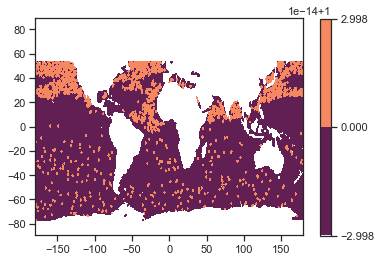

In [11]:
# Find RNA:Protein ratio
rna2pro = mPrna_mNcel/(fracP_rna * nprot)   # Equation (S11), total RNA:DNA mass ratio

# Find the mass of N in RNA relative to the mass of N in the cell
mNrna_mNcel = rna2pro * fracN_rna * nprot

# Find the total fraction of P in the cell
fracP_cel = fracN_cel*pn_ratio_mass

# Solve for the mass of N in protein to the mass of N in the cell
mNpro_mNcel = (fracN_cel/fracP_cel) * pn_ratio_mass - mNrna_mNcel

# Solve for the mass of protein and RNA relative to total cell mass
mTOTpro_mTOTcel = mNpro_mNcel * (fracN_cel/fracN_pro)
mTOTrna_mTOTcel = mTOTpro_mTOTcel * rna2pro

# Estimate mass of Chlorophyll using Chl:C relationship with growth rate and irradiance of Inomura et al. (2020)
mCchl_mCcel = A_chl * mu*24.0 + B_chl
mTOTchl_mTOTcel = mCchl_mCcel * (fracC_cel / fracC_chl)

# Solve for the mass of carbohydrate and non-P lipid relative to total cell mass
car2lip = 0.9    # (Finkel et al 2016 PLoS One)
remainder = 1.0 - ( mTOTpro_mTOTcel +
                    mTOTrna_mTOTcel +
                    mTOTchl_mTOTcel + 
                    mTOTdna_mTOTcel +
                    mTOTatp_mTOTcel )
mTOTlip_mTOTcel = remainder / (1.0 + car2lip) - mTOTpli_mTOTcel
mTOTcar_mTOTcel = remainder - (mTOTlip_mTOTcel + mTOTpli_mTOTcel)


# check that all fractions sum to 1
total = ( mTOTcar_mTOTcel + 
          mTOTlip_mTOTcel +
          mTOTpro_mTOTcel +
          mTOTrna_mTOTcel +
          mTOTchl_mTOTcel + 
          mTOTpli_mTOTcel +
          mTOTdna_mTOTcel +
          mTOTatp_mTOTcel )

plt.figure()
plt.contourf(lon,lat,total[0,:,:])
plt.colorbar()

## Step 5 - Recalculate C:N:P and predict the -O2:P demand of aerobic respiration

In [12]:
# Calculate molarC, molarH, molarO, molarN, molarP
molarC = (fracC_car*mTOTcar_mTOTcel + fracC_pro*mTOTpro_mTOTcel + fracC_lip*mTOTlip_mTOTcel + \
              fracC_pli*mTOTpli_mTOTcel + fracC_rna*mTOTrna_mTOTcel + fracC_dna*mTOTdna_mTOTcel + \
              fracC_atp*mTOTatp_mTOTcel + fracC_chl*mTOTchl_mTOTcel) / 12.0
molarH = (fracH_car*mTOTcar_mTOTcel + fracH_pro*mTOTpro_mTOTcel + fracH_lip*mTOTlip_mTOTcel + \
              fracH_pli*mTOTpli_mTOTcel + fracH_rna*mTOTrna_mTOTcel + fracH_dna*mTOTdna_mTOTcel + \
              fracH_atp*mTOTatp_mTOTcel + fracH_chl*mTOTchl_mTOTcel) / 1.0
molarO = (fracO_car*mTOTcar_mTOTcel + fracO_pro*mTOTpro_mTOTcel + fracO_lip*mTOTlip_mTOTcel + \
              fracO_pli*mTOTpli_mTOTcel + fracO_rna*mTOTrna_mTOTcel + fracO_dna*mTOTdna_mTOTcel + \
              fracO_atp*mTOTatp_mTOTcel + fracO_chl*mTOTchl_mTOTcel) / 16.0
molarN = (fracN_car*mTOTcar_mTOTcel + fracN_pro*mTOTpro_mTOTcel + fracN_lip*mTOTlip_mTOTcel + \
              fracN_pli*mTOTpli_mTOTcel + fracN_rna*mTOTrna_mTOTcel + fracN_dna*mTOTdna_mTOTcel + \
              fracN_atp*mTOTatp_mTOTcel + fracN_chl*mTOTchl_mTOTcel) / 14.0
molarP = (fracP_car*mTOTcar_mTOTcel + fracP_pro*mTOTpro_mTOTcel + fracP_lip*mTOTlip_mTOTcel + \
              fracP_pli*mTOTpli_mTOTcel + fracP_rna*mTOTrna_mTOTcel + fracP_dna*mTOTdna_mTOTcel + \
              fracP_atp*mTOTatp_mTOTcel + fracP_chl*mTOTchl_mTOTcel ) / 31.0

# calculate molar C:H:O:N:P ratio of mean organic matter
cp_ratio_mole = molarC/molarP
hp_ratio_mole = molarH/molarP
op_ratio_mole = molarO/molarP
np_ratio_mole = molarN/molarP

# calculate the demands of aerobic and anaerobic remineralisation (O2:P and NO3:P) (Paulmier et al. 2009)
oxyres_ratio = -(cp_ratio_mole + 0.25*hp_ratio_mole - 0.5*op_ratio_mole 
                 - 0.75*np_ratio_mole + 1.25) - 2.0*np_ratio_mole
denres_ratio = -0.8*(cp_ratio_mole + 0.25*hp_ratio_mole - 0.5*op_ratio_mole 
                     - 0.75*np_ratio_mole + 1.25) - 0.6*np_ratio_mole

respQ_sum = -(oxyres_ratio * (1.0/cp_ratio_mole))
respQ = -(oxyres_ratio + 2.0*np_ratio_mole) * (1.0/cp_ratio_mole)


### do Galbraith & Martiny 2015 versions
hp_ratio_GM15 = 2*cp_ratio_GM15 + 3*np_ratio_GM15 + 3
op_ratio_GM15 = cp_ratio_GM15 + 4
oxyres_ratio_GM15 = -(cp_ratio_GM15 + 0.25*hp_ratio_GM15 - 0.5*op_ratio_GM15 
                      - 0.75*np_ratio_GM15 + 1.25) - 2.0*np_ratio_GM15
denres_ratio_GM15 = -0.8*(cp_ratio_GM15 + 0.25*hp_ratio_GM15 - 0.5*op_ratio_GM15
                     - 0.75*np_ratio_GM15 + 1.25) - 0.6*np_ratio_GM15

respQ_sum_GM15 = -(oxyres_ratio_GM15 * (1.0/cp_ratio_GM15))
respQ_GM15 = -(oxyres_ratio_GM15 + 2.0*np_ratio_GM15) * (1.0/cp_ratio_GM15)


# Save predicted biomolecular compositions and stoichiometry

In [13]:
#%% save monthly output (12 x 180 x 360) as netCDF file

os.chdir('C:\\Users\\pearseb\\Dropbox\\PostDoc\\collaborations\\Tatsuro & Moreno\\data')

os.remove('biom_stoich_monthly_Inomura20.nc')
data = nc.Dataset('biom_stoich_monthly_Inomura20.nc', 'w', format='NETCDF4_CLASSIC')

mnd = data.createDimension('t', 12)
xd = data.createDimension('x', 360)
yd = data.createDimension('y', 180)

mnthv = data.createVariable('month', np.float64, ('t',))
lonv = data.createVariable('lon', np.float64, ('x',))
latv = data.createVariable('lat', np.float64, ('y',))
cpv = data.createVariable('C_P', np.float64, ('t', 'y', 'x'))
npv = data.createVariable('N_P', np.float64, ('t', 'y', 'x'))
opv = data.createVariable('O_P', np.float64, ('t', 'y', 'x'))
hpv = data.createVariable('H_P', np.float64, ('t', 'y', 'x'))
o2pv = data.createVariable('O2_P', np.float64, ('t', 'y', 'x'))
no3pv = data.createVariable('NO3_P', np.float64, ('t', 'y', 'x'))
rv = data.createVariable('RQ', np.float64, ('t', 'y', 'x'))
rsumv = data.createVariable('RQnit', np.float64, ('t', 'y', 'x'))
carv = data.createVariable('Carbohydrate', np.float64, ('t', 'y', 'x'))
lipv = data.createVariable('Lipid', np.float64, ('t', 'y', 'x'))
pliv = data.createVariable('Phospholipid', np.float64, ('t', 'y', 'x'))
prov = data.createVariable('Protein', np.float64, ('t', 'y', 'x'))
rnav = data.createVariable('RNA', np.float64, ('t', 'y', 'x'))
rchl = data.createVariable('Chlorophyll', np.float64, ('t', 'y', 'x'))


data.description = 'predicted biomolecular composition and stoichiometry of phytoplankton in the world ocean'
data.history = "Created by Pearse J. Buchanan on 10th Feb 2022, authors = PJ Buchanan, Tatsuro Tanioka, Allison Moreno"
data.source = "Data used included temperature, nitrate and phosphate averaged over the mixed layer from World Ocean Atlas (2018), and phytoplankton growth rate and mixed layer depths from Tanioka et al. (2020) Frontiers in Marine Science."

mnthv.units = "month"
lonv.units = "degrees_east"
latv.units = "degrees_north"
cpv.units = "ratio"
npv.units = "ratio"
opv.units = "ratio"
hpv.units = "ratio"
o2pv.units = "ratio"
no3pv.units = "ratio"
rv.units = "ratio"
rsumv.units = "ratio"
carv.units = "fraction"
lipv.units = "fraction"
pliv.units = "fraction"
prov.units = "fraction"
rnav.units = "fraction"
rchl.units = "fraction"

mnthv.standard_name = "month"
lonv.standard_name = "longitude"
latv.standard_name = "latitude"
cpv.standard_name = "organic carbon to phosphorus"
npv.standard_name = "organic nitrogen to phosphorus"
opv.standard_name = "organic oxygen to phosphorus"
hpv.standard_name = "organic hydrogen to phosphorus"
o2pv.standard_name = "dissolved oxygen required to remineralise one unit of organic phosphorus"
no3pv.standard_name = "nitrate required to remineralise one unit of organic phosphorus"
rv.standard_name = "dissolved oxygen required to remineralise one unit of organic carbon"
rsumv.standard_name = "dissolved oxygen required to remineralise one unit of organic carbon (plus nitrification)"
carv.standard_name = "fraction carbohydrate within organic matter (by mass)"
lipv.standard_name = "fraction lipid (non-phospholipid) within organic matter (by mass)"
pliv.standard_name = "fraction phospholipid within organic matter (by mass)"
prov.standard_name = "fraction protein within organic matter (by mass)"
rnav.standard_name = "fraction RNA within organic matter (by mass)"
rchl.standard_name = "fraction chlorophyll within organic matter (by mass)"

mnthv.axis = "T"
lonv.axis = "X"
latv.axis = "Y"

cpv.coordinates = "t y x"
npv.coordinates = "t y x"
opv.coordinates = "t y x"
hpv.coordinates = "t y x"
o2pv.coordinates = "t y x"
no3pv.coordinates = "t y x"
rv.coordinates = "t y x"
rsumv.coordinates = "t y x"
carv.coordinates = "t y x"
lipv.coordinates = "t y x"
pliv.coordinates = "t y x"
prov.coordinates = "t y x"
rnav.coordinates = "t y x"
rchl.coordinates = "t y x"

months = np.arange(1,13,1)

mnthv[:] = months
lonv[:] = lon
latv[:] = lat
cpv[:,:,:] = cp_ratio_mole
npv[:,:,:] = np_ratio_mole
opv[:,:,:] = op_ratio_mole
hpv[:,:,:] = hp_ratio_mole
o2pv[:,:,:] = -oxyres_ratio
no3pv[:,:,:] = -denres_ratio
rv[:,:,:] = respQ
rsumv[:,:,:] = respQ_sum
carv[:,:,:] = mTOTcar_mTOTcel
lipv[:,:,:] = mTOTlip_mTOTcel
pliv[:,:,:] = mTOTpli_mTOTcel
prov[:,:,:] = mTOTpro_mTOTcel
rnav[:,:,:] = mTOTrna_mTOTcel
rchl[:,:,:] = mTOTchl_mTOTcel


data.close()


In [14]:

#%% save monthly output (12 x 180 x 360) as netCDF file

os.chdir('C:\\Users\\pearseb\\Dropbox\\PostDoc\\collaborations\\Tatsuro & Moreno\\data')

os.remove('GM15_stoich_monthly.nc')
data = nc.Dataset('GM15_stoich_monthly.nc', 'w', format='NETCDF4_CLASSIC')

mnd = data.createDimension('t', 12)
xd = data.createDimension('x', 360)
yd = data.createDimension('y', 180)

mnthv = data.createVariable('month', np.float64, ('t',))
lonv = data.createVariable('lon', np.float64, ('x',))
latv = data.createVariable('lat', np.float64, ('y',))
cpv = data.createVariable('C_P', np.float64, ('t', 'y', 'x'))
npv = data.createVariable('N_P', np.float64, ('t', 'y', 'x'))
opv = data.createVariable('O_P', np.float64, ('t', 'y', 'x'))
hpv = data.createVariable('H_P', np.float64, ('t', 'y', 'x'))
o2pv = data.createVariable('O2_P', np.float64, ('t', 'y', 'x'))
no3pv = data.createVariable('NO3_P', np.float64, ('t', 'y', 'x'))
rv = data.createVariable('RQ', np.float64, ('t', 'y', 'x'))
rsumv = data.createVariable('RQnit', np.float64, ('t', 'y', 'x'))


data.description = 'predicted biomolecular composition and stoichiometry of phytoplankton in the world ocean'
data.history = "Created by Pearse J. Buchanan on 10th Feb 2022, authors = PJ Buchanan, Tatsuro Tanioka, Allison Moreno"
data.source = "Data used included temperature, nitrate and phosphate averaged over the mixed layer from World Ocean Atlas (2018), and phytoplankton growth rate and mixed layer depths from Tanioka et al. (2020) Frontiers in Marine Science."


mnthv.units = "month"
lonv.units = "degrees_east"
latv.units = "degrees_north"
cpv.units = "ratio"
npv.units = "ratio"
opv.units = "ratio"
hpv.units = "ratio"
o2pv.units = "ratio"
no3pv.units = "ratio"
rv.units = "ratio"
rsumv.units = "ratio"

mnthv.standard_name = "month"
lonv.standard_name = "longitude"
latv.standard_name = "latitude"
cpv.standard_name = "organic carbon to phosphorus"
npv.standard_name = "organic nitrogen to phosphorus"
opv.standard_name = "organic oxygen to phosphorus"
hpv.standard_name = "organic hydrogen to phosphorus"
o2pv.standard_name = "dissolved oxygen required to remineralise one unit of organic phosphorus"
no3pv.standard_name = "nitrate required to remineralise one unit of organic phosphorus"
rv.standard_name = "dissolved oxygen required to remineralise one unit of organic carbon"
rsumv.standard_name = "dissolved oxygen required to remineralise one unit of organic carbon (plus nitrification)"

mnthv.axis = "T"
lonv.axis = "X"
latv.axis = "Y"

cpv.coordinates = "t y x"
npv.coordinates = "t y x"
opv.coordinates = "t y x"
hpv.coordinates = "t y x"
o2pv.coordinates = "t y x"
no3pv.coordinates = "t y x"
rv.coordinates = "t y x"
rsumv.coordinates = "t y x"

months = np.arange(1,13,1)

mnthv[:] = months
lonv[:] = lon
latv[:] = lat
cpv[:,:,:] = cp_ratio_GM15
npv[:,:,:] = np_ratio_GM15
opv[:,:,:] = op_ratio_GM15
hpv[:,:,:] = hp_ratio_GM15
o2pv[:,:,:] = -oxyres_ratio_GM15
no3pv[:,:,:] = -denres_ratio_GM15
rv[:,:,:] = respQ_GM15
rsumv[:,:,:] = respQ_sum_GM15


data.close()


# Figures

In [15]:

# for annual averaging
mon_weights = [31,28.25,31,30,31,30,31,31,30,31,30,31]

# for mapping, add additional wrapped longitude
lons,lats = np.meshgrid(lon,lat)
lons = np.concatenate((lons[:,:], lons[:,0,np.newaxis]+360),axis=1)
lats = np.concatenate((lats[:,:], lats[:,0,np.newaxis]),axis=1)

# wrap on arrays for plotting 
np_ratio_mole = np.ma.concatenate((np_ratio_mole[:,:,:], np_ratio_mole[:,:,0,np.newaxis]),axis=2)
cp_ratio_mole = np.ma.concatenate((cp_ratio_mole[:,:,:], cp_ratio_mole[:,:,0,np.newaxis]),axis=2)
op_ratio_mole = np.ma.concatenate((op_ratio_mole[:,:,:], op_ratio_mole[:,:,0,np.newaxis]),axis=2)
hp_ratio_mole = np.ma.concatenate((hp_ratio_mole[:,:,:], hp_ratio_mole[:,:,0,np.newaxis]),axis=2)
oxyres_ratio = np.ma.concatenate((oxyres_ratio[:,:,:], oxyres_ratio[:,:,0,np.newaxis]),axis=2)
denres_ratio = np.ma.concatenate((denres_ratio[:,:,:], denres_ratio[:,:,0,np.newaxis]),axis=2)
respQ_sum = np.ma.concatenate((respQ_sum[:,:,:], respQ_sum[:,:,0,np.newaxis]),axis=2)
respQ = np.ma.concatenate((respQ[:,:,:], respQ[:,:,0,np.newaxis]),axis=2)
mTOTcar_mTOTcel = np.ma.concatenate((mTOTcar_mTOTcel[:,:,:], mTOTcar_mTOTcel[:,:,0,np.newaxis]),axis=2)
mTOTlip_mTOTcel = np.ma.concatenate((mTOTlip_mTOTcel[:,:,:], mTOTlip_mTOTcel[:,:,0,np.newaxis]),axis=2)
mTOTpro_mTOTcel = np.ma.concatenate((mTOTpro_mTOTcel[:,:,:], mTOTpro_mTOTcel[:,:,0,np.newaxis]),axis=2)
mTOTchl_mTOTcel = np.ma.concatenate((mTOTchl_mTOTcel[:,:,:], mTOTchl_mTOTcel[:,:,0,np.newaxis]),axis=2)
mTOTpli_mTOTcel = np.ma.concatenate((mTOTpli_mTOTcel[:,:,:], mTOTpli_mTOTcel[:,:,0,np.newaxis]),axis=2)
mTOTrna_mTOTcel = np.ma.concatenate((mTOTrna_mTOTcel[:,:,:], mTOTrna_mTOTcel[:,:,0,np.newaxis]),axis=2)
temp = np.ma.concatenate((temp[:,:,:], temp[:,:,0,np.newaxis]),axis=2)
mu = np.ma.concatenate((mu[:,:,:], mu[:,:,0,np.newaxis]),axis=2)
nitr = np.ma.concatenate((nitr[:,:,:], nitr[:,:,0,np.newaxis]),axis=2)
phos = np.ma.concatenate((phos[:,:,:], phos[:,:,0,np.newaxis]),axis=2)


proj = ccrs.Robinson(central_longitude=205.0)


lat_labs = ['80$^{\circ}$S', '60$^{\circ}$S', '40$^{\circ}$S', '20$^{\circ}$S', '0$^{\circ}$', \
        '20$^{\circ}$N', '40$^{\circ}$N', '60$^{\circ}$N', '80$^{\circ}$N']
lon_labs = ['0$^{\circ}$E', '50$^{\circ}$E', '100$^{\circ}$E', '150$^{\circ}$E', '200$^{\circ}$E', \
        '250$^{\circ}$E', '300$^{\circ}$E', '350$^{\circ}$E']


## Stoichiometric ratios

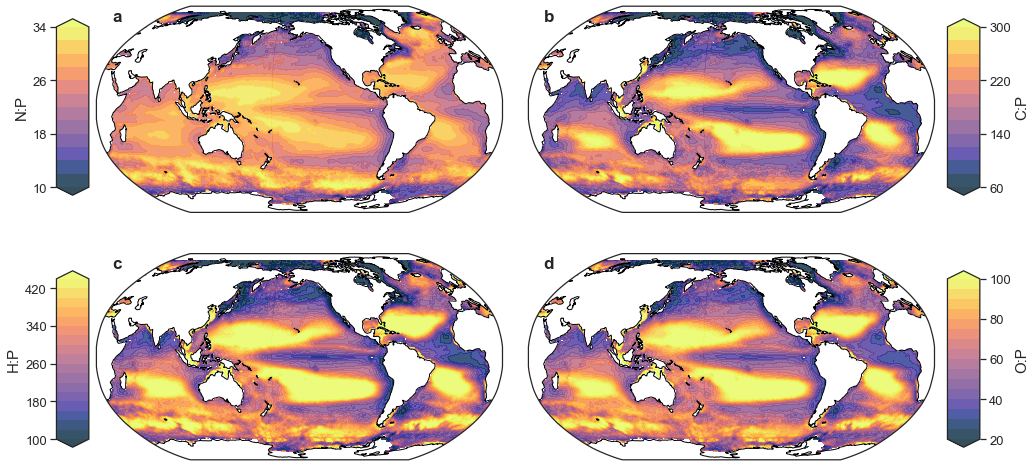

In [18]:
np_an = np.ma.average(np_ratio_mole, axis=0, weights=mon_weights)
cp_an = np.ma.average(cp_ratio_mole, axis=0, weights=mon_weights)
hp_an = np.ma.average(hp_ratio_mole, axis=0, weights=mon_weights)
op_an = np.ma.average(op_ratio_mole, axis=0, weights=mon_weights)

colmap1 = cmocean.tools.lighten(cmo.thermal,0.8)
colmap2 = cmocean.tools.lighten(cmo.thermal,0.8)
colmap3 = cmocean.tools.lighten(cmo.thermal,0.8)
colmap4 = cmocean.tools.lighten(cmo.thermal,0.8)

levs1 = np.arange(10,35,2)
levs2 = np.arange(60,301,20)
levs3 = np.arange(100,441,20)
levs4 = np.arange(20,101,5)

fstic = 13
fslab = 15
alf = 0.7
wid = 1.0

fig = plt.figure(figsize=(15,7), facecolor='w')
gs = GridSpec(2,2)

ax1 = plt.subplot(gs[0,0], projection=proj)
ax1.tick_params(labelsize=fstic)
ax1.coastlines()
p1 = plt.contourf(lons,lats, np_an, levels=levs1, cmap=colmap1, transform=ccrs.PlateCarree(),
                  vmin=np.min(levs1), vmax=np.max(levs1), extend='both')

ax2 = plt.subplot(gs[0,1], projection=proj)
ax2.tick_params(labelsize=fstic)
ax2.coastlines()
p2 = plt.contourf(lons,lats, cp_an, levels=levs2, cmap=colmap2, transform=ccrs.PlateCarree(),
                  vmin=np.min(levs2), vmax=np.max(levs2), extend='both')

ax3 = plt.subplot(gs[1,0], projection=proj)
ax3.tick_params(labelsize=fstic)
ax3.coastlines()
p3 = plt.contourf(lons,lats, hp_an, levels=levs3, cmap=colmap1, transform=ccrs.PlateCarree(),
                  vmin=np.min(levs3), vmax=np.max(levs3), extend='both')

ax4 = plt.subplot(gs[1,1], projection=proj)
ax4.tick_params(labelsize=fstic)
ax4.coastlines()
p4 = plt.contourf(lons,lats, op_an, levels=levs4, cmap=colmap4, transform=ccrs.PlateCarree(),
                  vmin=np.min(levs4), vmax=np.max(levs4), extend='both')


#plt.text(0.5,0.95, 'Input fields', transform=fig.transFigure, fontsize=fslab, ha='center', va='center')

plt.subplots_adjust(top=0.95,bottom=0.05,left=0.1,right=0.9, wspace=0.0)

xx = 0.05; yy= 0.95
plt.text(xx, yy, 'a', transform=ax1.transAxes, ha='center', va='center', fontsize=fslab+2, fontweight='bold')
plt.text(xx, yy, 'b', transform=ax2.transAxes, ha='center', va='center', fontsize=fslab+2, fontweight='bold')
plt.text(xx, yy, 'c', transform=ax3.transAxes, ha='center', va='center', fontsize=fslab+2, fontweight='bold')
plt.text(xx, yy, 'd', transform=ax4.transAxes, ha='center', va='center', fontsize=fslab+2, fontweight='bold')


cbax1 = fig.add_axes([0.075, 0.575, 0.03, 0.35])
cbar1 = plt.colorbar(p1, cax=cbax1, orientation='vertical', ticks=levs1[::4])
cbar1.ax.set_ylabel('N:P', fontsize=fslab)
cbar1.ax.tick_params(labelsize=fstic, right=False, labelright=False, left=True, labelleft=True)
cbax1.yaxis.set_label_position('left')

cbax2 = fig.add_axes([0.90, 0.575, 0.03, 0.35])
cbar2 = plt.colorbar(p2, cax=cbax2, orientation='vertical', ticks=levs2[::4])
cbar2.ax.set_ylabel('C:P', fontsize=fslab)
cbar2.ax.tick_params(labelsize=fstic)

cbax3 = fig.add_axes([0.075, 0.075, 0.03, 0.35])
cbar3 = plt.colorbar(p3, cax=cbax3, orientation='vertical', ticks=levs3[::4])
cbar3.ax.set_ylabel('H:P', fontsize=fslab)
cbar3.ax.tick_params(labelsize=fstic, right=False, labelright=False, left=True, labelleft=True)
cbax3.yaxis.set_label_position('left')

cbax4 = fig.add_axes([0.90, 0.075, 0.03, 0.35])
cbar4 = plt.colorbar(p4, cax=cbax4, orientation='vertical', ticks=levs4[::4])
cbar4.ax.set_ylabel('O:P', fontsize=fslab)
cbar4.ax.tick_params(labelsize=fstic)

## Primary biomolecules

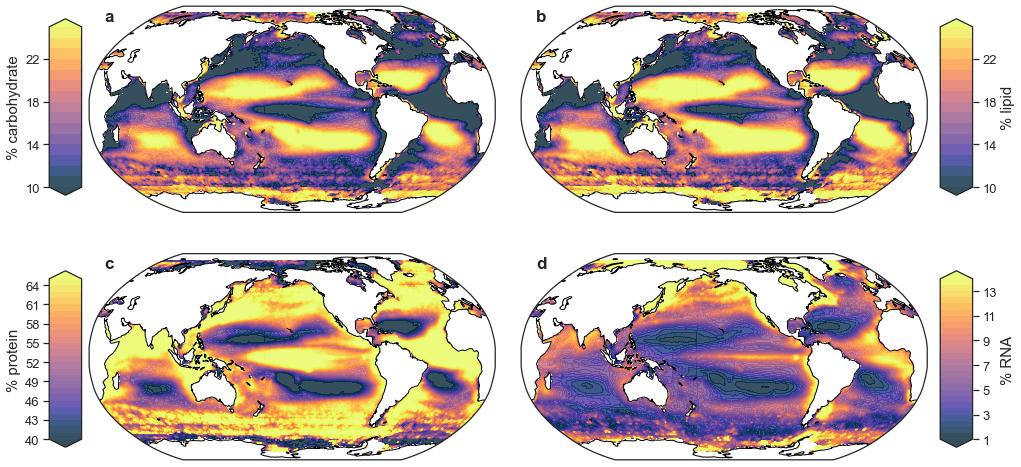

In [22]:
car_an = np.ma.average(mTOTcar_mTOTcel*100, axis=0, weights=mon_weights)
lip_an = np.ma.average((mTOTlip_mTOTcel+mTOTpli_mTOTcel)*100, axis=0, weights=mon_weights)
pro_an = np.ma.average(mTOTpro_mTOTcel*100, axis=0, weights=mon_weights)
rna_an = np.ma.average(mTOTrna_mTOTcel*100, axis=0, weights=mon_weights)

colmap1 = cmocean.tools.lighten(cmo.thermal,0.8)
colmap2 = cmocean.tools.lighten(cmo.thermal,0.8)
colmap3 = cmocean.tools.lighten(cmo.thermal,0.8)
colmap4 = cmocean.tools.lighten(cmo.thermal,0.8)

levs1 = np.arange(10,26,1)
levs2 = np.arange(10,26,1)
levs3 = np.arange(40,66,1)
levs4 = np.arange(1,14.1,0.5)

fstic = 13
fslab = 15
alf = 0.7
wid = 1.0

fig = plt.figure(figsize=(15,7), facecolor='w')
gs = GridSpec(2,2)

ax1 = plt.subplot(gs[0,0], projection=proj)
ax1.tick_params(labelsize=fstic)
ax1.coastlines()
p1 = plt.contourf(lons,lats, car_an, levels=levs1, cmap=colmap1, transform=ccrs.PlateCarree(),
                  vmin=np.min(levs1), vmax=np.max(levs1), extend='both')

ax2 = plt.subplot(gs[0,1], projection=proj)
ax2.tick_params(labelsize=fstic)
ax2.coastlines()
p2 = plt.contourf(lons,lats, lip_an, levels=levs2, cmap=colmap2, transform=ccrs.PlateCarree(),
                  vmin=np.min(levs2), vmax=np.max(levs2), extend='both')

ax3 = plt.subplot(gs[1,0], projection=proj)
ax3.tick_params(labelsize=fstic)
ax3.coastlines()
p3 = plt.contourf(lons,lats, pro_an, levels=levs3, cmap=colmap1, transform=ccrs.PlateCarree(),
                  vmin=np.min(levs3), vmax=np.max(levs3), extend='both')

ax4 = plt.subplot(gs[1,1], projection=proj)
ax4.tick_params(labelsize=fstic)
ax4.coastlines()
p4 = plt.contourf(lons,lats, rna_an, levels=levs4, cmap=colmap4, transform=ccrs.PlateCarree(),
                  vmin=np.min(levs4), vmax=np.max(levs4), extend='both')


#plt.text(0.5,0.95, 'Input fields', transform=fig.transFigure, fontsize=fslab, ha='center', va='center')

plt.subplots_adjust(top=0.95,bottom=0.05,left=0.1,right=0.9, wspace=0.0)

xx = 0.05; yy= 0.95
plt.text(xx, yy, 'a', transform=ax1.transAxes, ha='center', va='center', fontsize=fslab+2, fontweight='bold')
plt.text(xx, yy, 'b', transform=ax2.transAxes, ha='center', va='center', fontsize=fslab+2, fontweight='bold')
plt.text(xx, yy, 'c', transform=ax3.transAxes, ha='center', va='center', fontsize=fslab+2, fontweight='bold')
plt.text(xx, yy, 'd', transform=ax4.transAxes, ha='center', va='center', fontsize=fslab+2, fontweight='bold')


cbax1 = fig.add_axes([0.075, 0.575, 0.03, 0.35])
cbar1 = plt.colorbar(p1, cax=cbax1, orientation='vertical', ticks=levs1[::4])
cbar1.ax.set_ylabel('% carbohydrate', fontsize=fslab)
cbar1.ax.tick_params(labelsize=fstic, right=False, labelright=False, left=True, labelleft=True)
cbax1.yaxis.set_label_position('left')

cbax2 = fig.add_axes([0.90, 0.575, 0.03, 0.35])
cbar2 = plt.colorbar(p2, cax=cbax2, orientation='vertical', ticks=levs2[::4])
cbar2.ax.set_ylabel('% lipid', fontsize=fslab)
cbar2.ax.tick_params(labelsize=fstic)

cbax3 = fig.add_axes([0.075, 0.075, 0.03, 0.35])
cbar3 = plt.colorbar(p3, cax=cbax3, orientation='vertical', ticks=levs3[::3])
cbar3.ax.set_ylabel('% protein', fontsize=fslab)
cbar3.ax.tick_params(labelsize=fstic, right=False, labelright=False, left=True, labelleft=True)
cbax3.yaxis.set_label_position('left')

cbax4 = fig.add_axes([0.90, 0.075, 0.03, 0.35])
cbar4 = plt.colorbar(p4, cax=cbax4, orientation='vertical', ticks=levs4[::4])
cbar4.ax.set_ylabel('% RNA', fontsize=fslab)
cbar4.ax.tick_params(labelsize=fstic)

## N:P, C:P, -O2:P, -O2:C

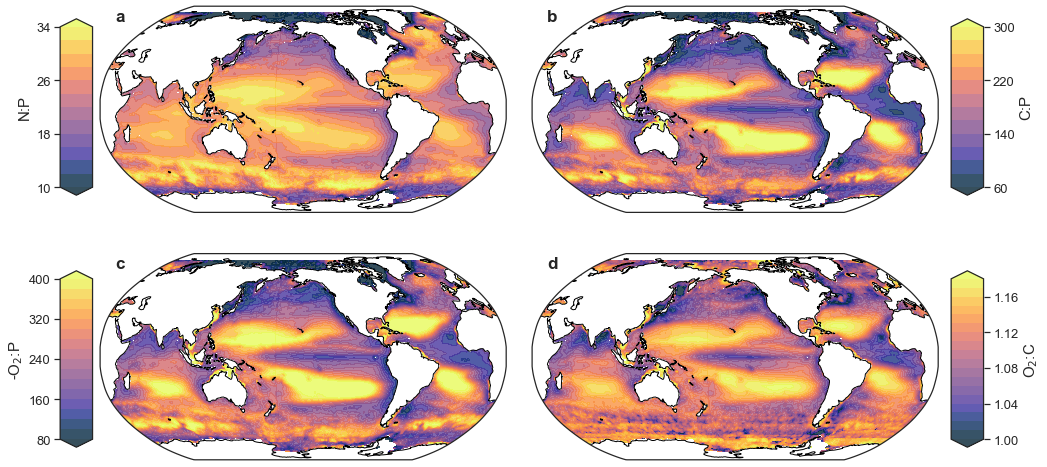

In [21]:

np_an = np.ma.average(np_ratio_mole, axis=0, weights=mon_weights)
cp_an = np.ma.average(cp_ratio_mole, axis=0, weights=mon_weights)
o2_an = np.ma.average(oxyres_ratio, axis=0, weights=mon_weights)
rq_an = np.ma.average(respQ, axis=0, weights=mon_weights)

colmap1 = cmocean.tools.lighten(cmo.thermal,0.8)
colmap2 = cmocean.tools.lighten(cmo.thermal,0.8)
colmap3 = cmocean.tools.lighten(cmo.thermal,0.8)
colmap4 = cmocean.tools.lighten(cmo.thermal,0.8)

levs1 = np.arange(10,35,2)
levs2 = np.arange(60,301,20)
levs3 = np.arange(80,401,20)
levs4 = np.arange(1.0,1.181,0.01)

fstic = 13
fslab = 15
alf = 0.7
wid = 1.0

fig = plt.figure(figsize=(15,7), facecolor='w')
gs = GridSpec(2,2)

ax1 = plt.subplot(gs[0,0], projection=proj)
ax1.tick_params(labelsize=fstic)
ax1.coastlines()
p1 = plt.contourf(lons,lats, np_an, levels=levs1, cmap=colmap1, transform=ccrs.PlateCarree(),
                  vmin=np.min(levs1), vmax=np.max(levs1), extend='both')

ax2 = plt.subplot(gs[0,1], projection=proj)
ax2.tick_params(labelsize=fstic)
ax2.coastlines()
p2 = plt.contourf(lons,lats, cp_an, levels=levs2, cmap=colmap2, transform=ccrs.PlateCarree(),
                  vmin=np.min(levs2), vmax=np.max(levs2), extend='both')

ax3 = plt.subplot(gs[1,0], projection=proj)
ax3.tick_params(labelsize=fstic)
ax3.coastlines()
p3 = plt.contourf(lons,lats, -o2_an, levels=levs3, cmap=colmap1, transform=ccrs.PlateCarree(),
                  vmin=np.min(levs3), vmax=np.max(levs3), extend='both')

ax4 = plt.subplot(gs[1,1], projection=proj)
ax4.tick_params(labelsize=fstic)
ax4.coastlines()
p4 = plt.contourf(lons,lats, rq_an, levels=levs4, cmap=colmap4, transform=ccrs.PlateCarree(),
                  vmin=np.min(levs4), vmax=np.max(levs4), extend='both')


#plt.text(0.5,0.95, 'Input fields', transform=fig.transFigure, fontsize=fslab, ha='center', va='center')

plt.subplots_adjust(top=0.95,bottom=0.05,left=0.1,right=0.9, wspace=0.0)

xx = 0.05; yy= 0.95
plt.text(xx, yy, 'a', transform=ax1.transAxes, ha='center', va='center', fontsize=fslab+2, fontweight='bold')
plt.text(xx, yy, 'b', transform=ax2.transAxes, ha='center', va='center', fontsize=fslab+2, fontweight='bold')
plt.text(xx, yy, 'c', transform=ax3.transAxes, ha='center', va='center', fontsize=fslab+2, fontweight='bold')
plt.text(xx, yy, 'd', transform=ax4.transAxes, ha='center', va='center', fontsize=fslab+2, fontweight='bold')


cbax1 = fig.add_axes([0.075, 0.575, 0.03, 0.35])
cbar1 = plt.colorbar(p1, cax=cbax1, orientation='vertical', ticks=levs1[::4])
cbar1.ax.set_ylabel('N:P', fontsize=fslab)
cbar1.ax.tick_params(labelsize=fstic, right=False, labelright=False, left=True, labelleft=True)
cbax1.yaxis.set_label_position('left')

cbax2 = fig.add_axes([0.90, 0.575, 0.03, 0.35])
cbar2 = plt.colorbar(p2, cax=cbax2, orientation='vertical', ticks=levs2[::4])
cbar2.ax.set_ylabel('C:P', fontsize=fslab)
cbar2.ax.tick_params(labelsize=fstic)

cbax3 = fig.add_axes([0.075, 0.075, 0.03, 0.35])
cbar3 = plt.colorbar(p3, cax=cbax3, orientation='vertical', ticks=levs3[::4])
cbar3.ax.set_ylabel('-O$_2$:P', fontsize=fslab)
cbar3.ax.tick_params(labelsize=fstic, right=False, labelright=False, left=True, labelleft=True)
cbax3.yaxis.set_label_position('left')

cbax4 = fig.add_axes([0.90, 0.075, 0.03, 0.35])
cbar4 = plt.colorbar(p4, cax=cbax4, orientation='vertical', ticks=levs4[::4])
cbar4.ax.set_ylabel('O$_2$:C', fontsize=fslab)
cbar4.ax.tick_params(labelsize=fstic)